# Hyperparameter from Lottery Tickets
    * architecture LeNet 300-100 (28*28, 300, 100, 10)
    * training - 60.000 samples
    * testing - 10.000 samples
    * validation - 5.000 samples extracted from training
    * mini-batch - 60 samples
    * prunning - iteratively pruning of rate 20% (10% for the output layer)
    * iteration - each iteration of lottery ticket the network is trained for 50.000 iterations
    * earling stop - on validation, at every 100 iterations
    * teacher: Adam - learning rate = 0.0012
    * initialization - Gaussian Glorot
    * activation function - ?
    * critery Loss - ?

# some torch operations
    
    # torch.nn.init.normal_(tensor, mean=0.0, std=1.0) -> fills the tensor (from pytorch documentation)
    
    # torch_1 = torch.add(torch_1, torch_2) -> element wise summing
    # torch.sum(torch_1) -> inner sum over all the elements
    
    # torch_1.cross(torch_2) -> cross product (that likes determinant computing)
    # torch_1.mm(torch_2) -> multiplication of matrixes
    # torch_1.mul(torch_2) -> element wise multiplication
    
    # torch_1 = torch.div(torch_1, constant) -> element wise division
    
    # torch_1.t() -> transpose
    
    # torch_1.uniform_(0, 1) -> fills the torch_1 with a uniform distribution in [0, 1]
    # torch_1.bernoulli(torch_1) -> fills the torch_1 with a bernoulli probability with p as the each torch_1 elements
    #   w = torch.Tensor([0, 4, 8, 2]) # Create a tensor of weights
    #   torch_1 = torch.multinomial(w, 4, replacement=True) # Size 4: 3, 2, 1, 2 multinomial distribution
    # torch_1.normal(mean=, std=) -> fills the torch_1 with a normal distribution with a mean and a standard deviation

In [1]:
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as Init
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

## Getting the dataset

In [2]:
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 60
# percentage of training set to use as validation
valid_size = 0.1

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=False, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

## Defining the Neral Network

In [3]:
class FCN_Maskable(nn.Module):
    
    def __init__(self):
        super(FCN_Maskable, self).__init__()
        # Our x will be a 28 x 28 image
        # Our architecture is a LeNet 300-100
        self.input_ = 28 * 28
        self.hidden_1 = 300
        self.hidden_2 = 100
        self.output = 10
        
#         # the +1 is the inner bias
#         self.w_1 = torch.empty(hidden_1, input_+1, dtype=torch.float, requires_grad=True)
# #         self.w_1.normal(mean=0, std=np.sqrt(2.0/input+1))
#         Init.xavier_normal(self.w_1, gain=nn.init.calculate_gain('leaky_relu'))
        
#         self.w_2 = torch.empty(hidden_2, hidden_1+1, dtype=torch.float, requires_grad=True)
# #         self.w_2.normal(mean=0, std=np.sqrt(2.0/hidden_1+1))
#         Init.xavier_normal(self.w_2, gain=nn.init.calculate_gain('leaky_relu'))
        
#         self.w_3 = torch.empty(output, hidden_2+1, dtype=torch.float, requires_grad=True)
# #         self.w_3.normal(mean=0, std=np.sqrt(2.0/hidden_2+1))
#         Init.xavier_normal(self.w_3, gain=nn.init.calculate_gain('leaky_relu'))
        
#         self.parameters = nn.ParameterList([self.w_1, self.w_2, self.w_3])
# #         self.parameters = nn.ParameterList(self.w_1) + nn.ParameterList(self.w_2) + nn.ParameterList(self.w_3)
# #         self.parameters = [self.w_1, self.w_2, self.w_3]

        # the +1 is the inner bias
        self.w_1 = torch.nn.Parameter(torch.zeros(self.hidden_1, self.input_+1), requires_grad=True)
        Init.xavier_normal(self.w_1, gain=nn.init.calculate_gain('leaky_relu'))
        
        self.w_2 = torch.nn.Parameter(torch.zeros(self.hidden_2, self.hidden_1+1), requires_grad=True)
        Init.xavier_normal(self.w_2, gain=nn.init.calculate_gain('leaky_relu'))
        
        self.w_3 = torch.nn.Parameter(torch.zeros(self.output, self.hidden_2+1), requires_grad=True)
        Init.xavier_normal(self.w_3, gain=nn.init.calculate_gain('leaky_relu'))
        
        
    def forward(self, x):
        ones = torch.tensor([[1.0]])
        
        # flatten the image input
        x_ = x.view(self.input_, -1)
        
        # add hidden layer, with LeakyReLu activation
        x_ = torch.cat((x_, ones), dim=0)
        x_ = F.leaky_relu(self.w_1.mm(x_)) # original negative_slope=0.01
        # add hidden layer, with LeakyRelu activation function
        x_ = torch.cat((x_, ones), dim=0)
        x_ = F.leaky_relu(self.w_2.mm(x_))
        # add output layer
        x_ = torch.cat((x_, ones), dim=0)
        x_ = F.leaky_relu(self.w_3.mm(x_))
        
        return x_

## Preparing to train

In [4]:
model = FCN_Maskable()
print(model)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)

FCN_Maskable()


/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [5]:
# number of epochs to train the model
n_epochs = 10

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    train_loss_history.append(train_loss)
    validation_loss_history.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_maskable.pt')
        valid_loss_min = valid_loss

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 60 and 1 in dimension 1 at /opt/conda/conda-bld/pytorch_1549636813070/work/aten/src/TH/generic/THTensorMoreMath.cpp:1307

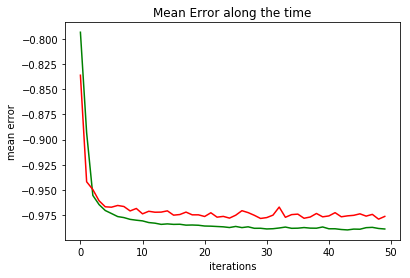

In [7]:
# picturing the results obtained
plt.plot(range(0, len(train_loss_history)), train_loss_history, color='green')
plt.plot(range(0, len(validation_loss_history)), validation_loss_history, color='red')
plt.xlabel('iterations')
plt.ylabel('mean error')
plt.title('Mean Error along the time')
plt.show()

## Using the test dataset

In [8]:
model.load_state_dict(torch.load('model_maskable.pt'))

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.074413

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 98% (1123/1135)
Test Accuracy of     2: 96% (1001/1032)
Test Accuracy of     3: 97% (984/1010)
Test Accuracy of     4: 97% (960/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 97% (935/958)
Test Accuracy of     7: 96% (993/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 97% (981/1009)

Test Accuracy (Overall): 97% (9764/10000)
